# DATA EXPLORATION

In [1]:
# For Path handling
from pathlib import Path

# For General Data Wrangling and Calculations
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP
import nltk

# For stop word filtering
nltk.download("stopwords")
from nltk.corpus import stopwords

# For tokenizing
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')

# For lemmatizing
from nltk.stem import WordNetLemmatizer

# For regex
import re

# To plot wordcloud
from wordcloud import WordCloud

# For PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For UMAP
import umap
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/labs/lslab/drojas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/labs/lslab/drojas/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/labs/lslab/drojas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load input files and Data Wrangling

In [2]:
# Train data path
train_df = Path("../data/Raw/medical_tc_train.csv")
# Test data path
test_df = Path("../data/Raw/medical_tc_test.csv")
# Labels path
labels_df = Path("../data/Raw/medical_tc_labels.csv")

# Open train data
train_df = pd.read_csv(train_df)
test_df = pd.read_csv(test_df)
labels_df = pd.read_csv(labels_df)

# Add Labels to Training and Testing sets
train_df = pd.merge(train_df,labels_df, how = "left", on = "condition_label")
test_df = pd.merge(test_df,labels_df, how = "left", on = "condition_label")

# Concatenate dataframes for general dataset exploration
full_df = pd.concat([train_df, test_df])

# Visualize top 10 rows
print(f"Training set (length: {len(train_df)}):\n", train_df.head(10))
print(f"Test set (length: {len(test_df)}):\n", test_df.head(10))
print(f"Full dataset (length: {len(full_df)}):\n", full_df.head(10))

Training set (length: 11550):
    condition_label                                   medical_abstract  \
0                5  Tissue changes around loose prostheses. A cani...   
1                1  Neuropeptide Y and neuron-specific enolase lev...   
2                2  Sexually transmitted diseases of the colon, re...   
3                1  Lipolytic factors associated with murine and h...   
4                3  Does carotid restenosis predict an increased r...   
5                3  The shoulder in multiple epiphyseal dysplasia....   
6                2  The management of postoperative chylous ascite...   
7                4  Pharmacomechanical thrombolysis and angioplast...   
8                5  Color Doppler diagnosis of mechanical prosthet...   
9                5  Noninvasive diagnosis of right-sided extracard...   

                    condition_name  
0  general pathological conditions  
1                        neoplasms  
2        digestive system diseases  
3                

Define plots output directory

In [3]:
plots_out_dir = Path("../plots/")

## 1. Conditions Distribution
We will explore how the conditions are distributed in the train and test set.

Define function to plot condition distribution

In [17]:
def plot_condition_distribution(df, path_to_save):
    # Define a color palette for the conditions
    palette = {
        "neoplasms": "#1f77b4",
        "digestive system diseases": "#ff7f0e",
        "nervous system diseases": "#2ca02c",
        "cardiovascular diseases": "#d62728",
        "general pathological conditions": "#9467bd",
        "total": "#808080"
    }

    # Calculate the percentage of each condition in the entire dataset
    condition_counts = df["condition_name"].value_counts()
    total_count = condition_counts.sum()  # Total count of all conditions
    percentages = (condition_counts / total_count) * 100

    # Prepare data for pie chart
    pie_data = percentages.reset_index()
    pie_data.columns = ["Condition", "Percentage"]
    
    # Initialize figure
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # Left Plot: Countplot
    sns.countplot(
        data = df,
        x = "condition_name",
        palette = palette,
        hue = "condition_name",
        order = condition_counts.index,  # Ensures consistent ordering
        ax = axes[0],
        edgecolor = "black"
    )
    # Rotate x-axis labels to fit
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 90)
    # Change Axis titles
    axes[0].set_xlabel("Condition")
    axes[0].set_ylabel("Count")

    # Right Plot: Pie Chart
    axes[1].pie(
        pie_data["Percentage"], 
        labels = pie_data["Condition"], 
        autopct = "%1.1f%%",  # Display percentage on the chart
        startangle = 90,  # Start angle of the pie chart
        colors = [palette.get(cond, "#808080") for cond in pie_data["Condition"]],  # Use the palette colors
        wedgeprops = {"edgecolor": "black"}  # Add edges to make segments clear
    )
    
    # Adjust layout
    plt.tight_layout()

    # Save figure
    Path(path_to_save).mkdir(parents = True, exist_ok = True)  # Ensure directory exists
    plt.savefig(Path(path_to_save) / "conditions_distribution.png")

    # Display the figure
    plt.show()

Plot Conditions Distribution

/tmp/ipykernel_1495545/2337843651.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 90)


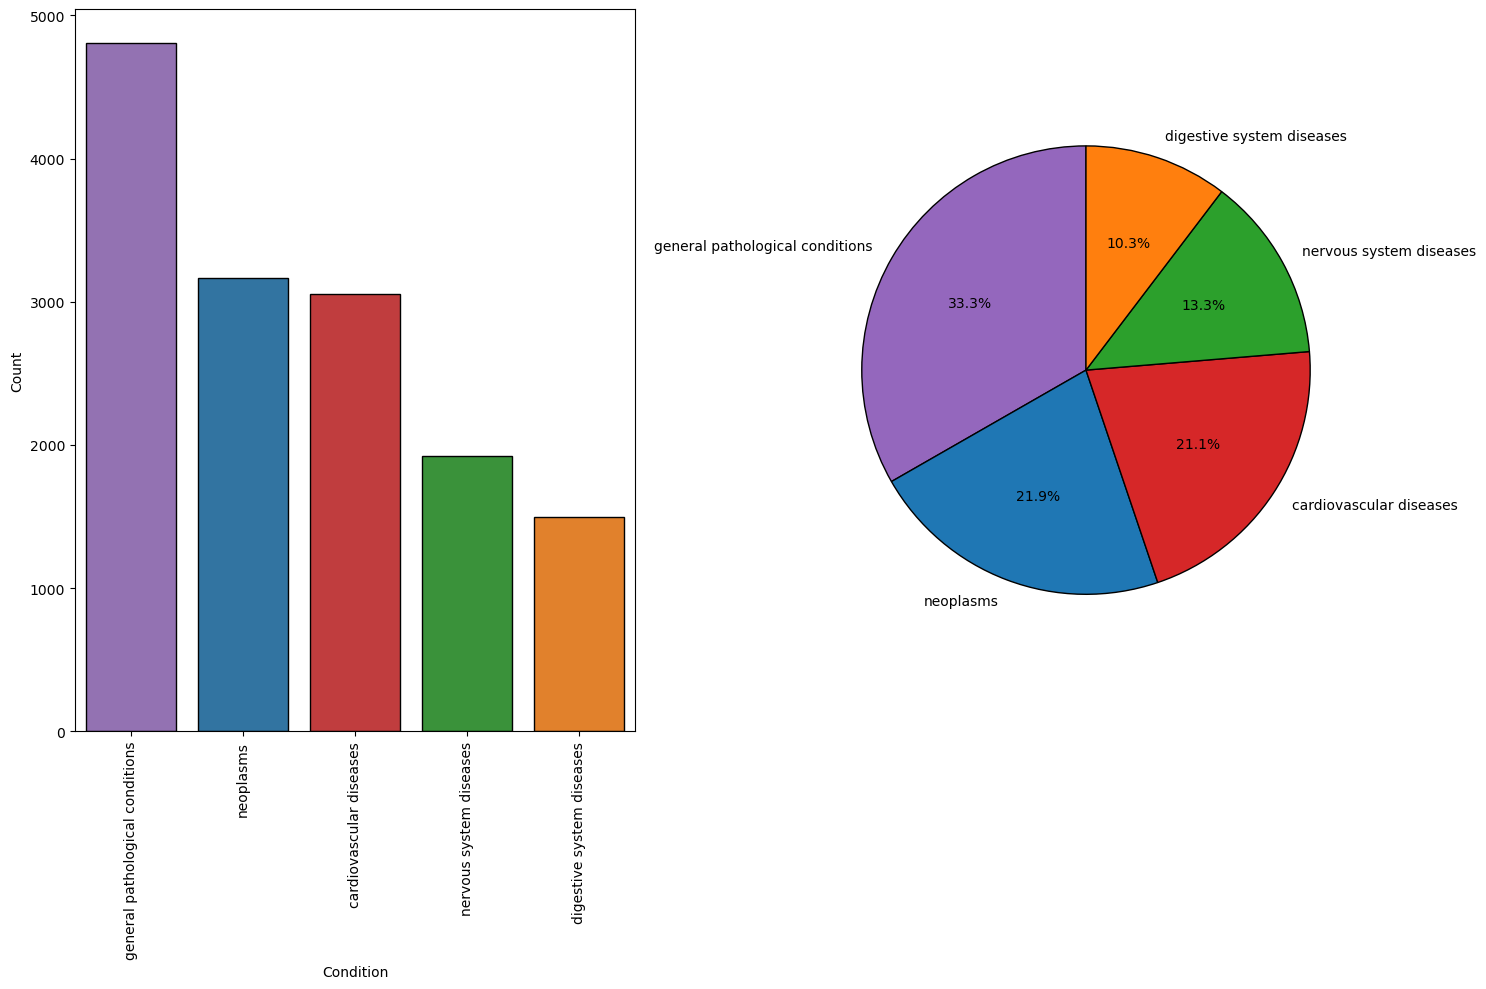

In [18]:
plot_condition_distribution(full_df, plots_out_dir)

# 2. Text Characteristics per Condition
We will study the characteristics of the text from each condition: number of letters, words, unique words, sentences, stopwords and non-stopwords.

Define function to calculate the features in the text

In [19]:
# Function to count stopwords
def count_stopwords(text):

    # Define stop words
    stop_words = set(stopwords.words("english"))

    # Define tokenizer
    tokens = word_tokenize(text)

    # Count stopwords
    stopwords_num = len([token for token in tokens if token not in stop_words])

    return stopwords_num

# Function to define all features
def define_text_features(df):
    # Count
    df["letters"] = df["medical_abstract"].apply(lambda x: len(x)) # Number of letters
    df["words"] = df["medical_abstract"].apply(lambda x: len(x.split(" "))) # Number of words
    df["unique_words"] = df["medical_abstract"].apply(lambda x: (len(set(x.split(" "))))) # Number of unique words
    df["sentences"] = df["medical_abstract"].apply(lambda x: len(x.split("."))) # Number of Senmtences
    df["stopwords"] = df["medical_abstract"].apply(lambda x: count_stopwords(x)) # Number of stopwords
    df["non_stopwords"] = df["words"] - df["stopwords"] # Number of non-stopwords

    return df

Get text features

In [20]:
features_df = define_text_features(full_df)

Define function to plot text characteristics

In [21]:
def plot_text_features(df, path_to_save):
    # Define a color palette for the conditions
    palette = {
        "neoplasms": "#1f77b4",
        "digestive system diseases": "#ff7f0e",
        "nervous system diseases": "#2ca02c",
        "cardiovascular diseases": "#d62728",
        "general pathological conditions": "#9467bd",
        "total": "#808080"
    }
    
    # Define columns to plot
    columns = ["letters", "words", "unique_words", "sentences", "stopwords", "non_stopwords"]

    # Define Figure and create axes grid (2x3)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Initialize loop to iterate through columns
    for i, col in enumerate(columns):
        # Plot with legend=False to prevent individual legends
        sns.kdeplot(data=df, x=col, hue="condition_name", palette=palette, ax=axes[i], legend=False)

        # Set title for each subplot
        axes[i].set_title(f"{col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Density")

    # Plot the first plot with legend=True to generate the legend
    sns.kdeplot(data=df, x=columns[0], hue="condition_name", palette=palette, legend=True)

    # Get handles and labels from the last plot (which has the legend)
    handles, labels = axes[0].get_legend_handles_labels()

    # Create a shared legend and place it below the subplots
    fig.legend(handles, labels, loc = "center right", bbox_to_anchor=(0.5, -0.05), ncol=6)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save figure
    Path(path_to_save).mkdir(parents = True, exist_ok = True)  # Ensure directory exists
    plt.savefig(Path(path_to_save) / "features_per_condition.png")

    # Display the figure
    plt.show()

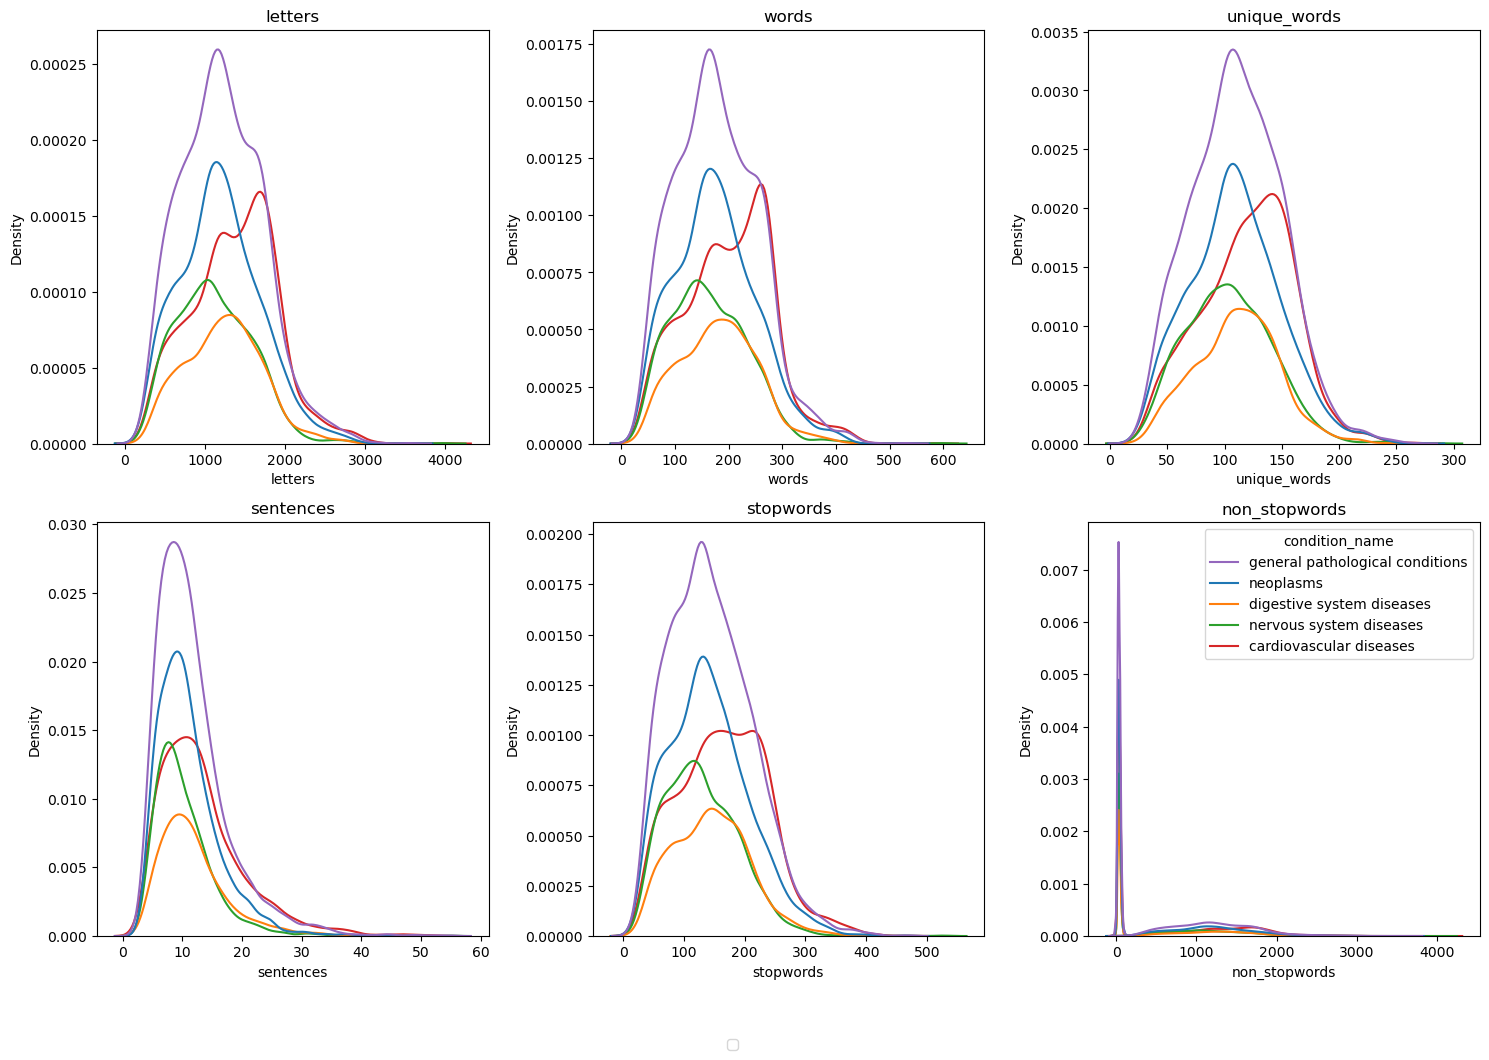

In [22]:
plot_text_features(features_df, plots_out_dir)

# 3. Text Processing
In this step we will proceed to clean the medical asbtracts following the next steps:

1. Tokenizing
2. Lowering text
3. Removing stopwords, extra spaces, numbers and special characters.

Define function to process text

In [5]:
def text_processing(df):

    # Define stop words
    stop_words = set(stopwords.words("english"))
    # Define lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Initialize loop to iterate through
    for i, row in df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]

        if isinstance(text, str):
            # Tokenize cell
            tokens = word_tokenize(text)

            # Remove stopwords
            clean_tokens = [token for token in tokens if token not in stop_words]

            # Lemmatize
            lemmas = [lemmatizer.lemmatize(token) for token in clean_tokens]

            # Detokenize text
            clean_text = " ".join(lemmas)
            # Remove potential spaces at the start and begining of text
            clean_text = clean_text.strip()

            # Lower text
            clean_text = clean_text.lower()

            # Remove
            clean_text = re.sub(r"\s+", " ", clean_text) # Extra spaces
            clean_text = re.sub(r"\d+", "", clean_text) # Digits
            clean_text = re.sub(r"\.+", ".",clean_text) # Extra Punkts
            clean_text = re.sub(r"\,+", ",",clean_text)  # Extra Comas

            # Save processed text
            df.loc[i, "medical_abstract"] = clean_text

        else:
            print(f"Medical Abstract number {i} might be empty!")

    return df

Process text

In [6]:
# Full Dataset
cleaned_full = text_processing(full_df)
# Train Dataset
cleaned_train = text_processing(train_df)
# Test Dataset
cleaned_test = text_processing(test_df)

# 4. Most Abundant Words per Condition
In this section, we will first explore the most abundant words and the most important expressions for each condition.

Define Function to plot most abundant words and most important expressions

In [26]:
def plot_abundant(df_filtered, condition, out_dir):

    # Define color palette
    palette = {
        "neoplasms": "#1f77b4",
        "digestive system diseases": "#ff7f0e",
        "nervous system diseases": "#2ca02c",
        "cardiovascular diseases": "#d62728",
        "general pathological conditions": "#9467bd",
        "total": "#808080"
    }
    
    # Initiate WordCloud plot
    plt.figure(figsize=(12,6))
    # Define Title
    plt.title(f"WorldCloud in {condition}")
    # Plot
    wc = WordCloud(background_color = "white",
                   max_words = 500,
                   width = 1600,
                   height = 800,
                   contour_width = 10,
                   contour_color = palette[condition]).generate(" ".join(df_filtered["medical_abstract"]))
    # Remove axis
    plt.axis(False)
    # show Plot
    plt.imshow(wc, interpolation = "bilinear")
    # Save figure
    plt.savefig(Path(out_dir) / f"wordcloud_{condition.replace(' ', '_')}.png")

    # Close plt
    plt.close()

    # Define df to plot most abundant words
    df_wc = pd.DataFrame(wc.words_.items(), columns=['Word', 'Frequency'])
    # Initiate plot
    plt.figure(figsize = (10,5))
    # Get top 20 words
    top_20_df = df_wc.head(20)
    # Add Title
    plt.title(f"Most Frequent word in {condition}")
    # Plot
    sns.barplot(data = top_20_df, x = "Frequency", y = "Word", color = palette[condition], edgecolor = "black")
    # Save figure
    plt.savefig(Path(out_dir) / f"top_words_{condition.replace(' ', '_')}.png")
    # Close plt
    plt.close()
    
def plot_abundant_per_condition(df, out_dir = plots_out_dir):

    # Define conditions
    conditions = df.condition_name.unique()

    # Initialize loop to iterate through conditions
    for condition in conditions:

        # Filter df
        df_filtered = df[df["condition_name"] == condition]

        # Plot most abundant words
        plot_abundant(df_filtered, condition, out_dir)

In [27]:
plot_abundant_per_condition(cleaned_full)

In [11]:
from datasets import Dataset

cleaned_train["label"] = cleaned_train["condition_label"] - 1

from sklearn.model_selection import train_test_split
train, validation = train_test_split(cleaned_train, test_size = 0.1)

train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validation)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

def preprocess_function(examples):
    return tokenizer(examples["medical_abstract"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True, num_proc=5, 
                         remove_columns=['condition_label', 'condition_name'])
tokenized_val = val_dataset.map(preprocess_function, batched=True, num_proc=5, 
                         remove_columns=['condition_label', 'condition_name'])

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

loading configuration file https://huggingface.co/dmis-lab/biobert-v1.1/resolve/main/config.json from cache at /home/labs/lslab/drojas/.cache/huggingface/transformers/f048b8136bae2b3abe91e9e82949295fb205887c84db3be2775e1cdb0ecfeeb9.d7812d36d3371e4d43299a0c4a938622c5251db0efa17a5d4d9b57037fcec823
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/dmis-lab/biobert-v1.1/resolve/main/vocab.txt from ca

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#2:   0%|          | 0/3 [00:00<?, ?ba/s]

#3:   0%|          | 0/3 [00:00<?, ?ba/s]

#4:   0%|          | 0/3 [00:00<?, ?ba/s]

/imppc/labs/lslab/drojas/miniconda3/envs/text_classification/lib/python3.10/site-packages/datasets/table.py:1292: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/imppc/labs/lslab/drojas/miniconda3/envs/text_classification/lib/python3.10/site-packages/datasets/table.py:1318: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "neoplasms", 1: "digestive system diseases", 2: "nervous system diseases", 3: "cardiovascular diseases", 4: "general pathological conditions"}
label2id = {"neoplasms": 0, "digestive system diseases": 1, "nervous system diseases": 2, "cardiovascular diseases": 3, "general pathological conditions": 4}

model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-v1.1", num_labels = 5, id2label = id2label, label2id = label2id
)

/imppc/labs/lslab/drojas/miniconda3/envs/text_classification/lib/python3.10/site-packages/transformers/modeling_utils.py:1331: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

In [47]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
cleaned_train["label"].unique()

array([4, 0, 1, 2, 3])

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs = 10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model("BioBert_MedAbs_Classifier_10")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, medical_abstract.
***** Running training *****
  Num examples = 10395
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6500


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score,accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, AutoConfig

from transformers import Trainer, TrainingArguments
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

import random
import os

## 5. Text Classification Model Training
In this section, we will train the BioBert Large Language Model to classify medical abstracts.

Transform train data into a traning dataset

In [4]:
train_dataset = Dataset.from_pandas(train_df)

# Show train dataset
train_dataset

Dataset({
    features: ['condition_label', 'medical_abstract', 'condition_name'],
    num_rows: 11550
})

Define Training Arguments

In [20]:
training_args = TrainingArguments(
    output_dir = Path("../model/"),
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 16,
    num_train_epochs = 6,
    evaluation_strategy = "steps",
    logging_steps = 250,
    save_strategy = "steps",
    load_best_model_at_end = True,
    weight_decay = 1e-2, 
    fp16 = True,# automatic mixed precision, AMP
    learning_rate = 1e-5, # 1e-5 -> 2e-5
    lr_scheduler_type = "linear",
    optim = "adamw_torch",
    metric_for_best_model = "accuracy",
    save_total_limit = 1,
    report_to = "none",
)

Add seed to everything

In [6]:
def seed_all():
    random.seed(777)
    os.environ['PYTHONHASHSEED'] = str(777)
    np.random.seed(777)
    torch.manual_seed(777)
    torch.cuda.manual_seed(777)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Run seed_all
seed_all()

Configure BioBert Model

In [25]:
model_config = AutoConfig.from_pretrained("dmis-lab/biobert-v1.1")

model_config.attention_probs_dropout_prob = 0.0
model_config.hidden_dropout_prob = 0.0
model_config.num_labels = 5
model_config.max_position_embeddings = 512

model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", config = model_config)
print("Freezing embeddings.")
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
        
if 1 > 0:
    print(f"Freezing {1} layers")
    for layer in model.bert.encoder.layer[:1]:
        for param in layer.parameters():
            param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freezing embeddings.
Freezing 1 layers


In [ ]:
model.distilbert.

Define Tokenizer and preprocess function

In [26]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Preprocess function
def preprocess_function(examples):
    return tokenizer(examples["medical_abstract"], truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [27]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Define function to calculate metrics

In [28]:
def calculate_metrics(eval_pred):
    predictions, labels = eval_pred

    accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
    f1 = f1_score(labels, np.argmax(predictions, axis=1), average='weighted')
    results = {
        'accuracy': accuracy,
        'f1_score': f1,
    }
    return results

Train BioBert Model

In [31]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Preprocess function
def preprocess_function(examples):
    return tokenizer(examples["medical_abstract"], truncation=True)

all_oof = []
all_true = []
fold_metrics = []

train, validation = train_test_split(train_df, test_size = 0.1)

for i in range(1,6):
    dataset_validation = Dataset.from_pandas(validation)
    dataset_training = Dataset.from_pandas(train)
    dataset = Dataset.from_pandas(train_df)
    # Validation Dataset
    tokenized_dataset_validation = dataset_validation.map(preprocess_function, num_proc = 5, remove_columns = ['condition_label', 'medical_abstract', 'condition_name'])
    # Train Dataset
    tokenized_dataset_training = dataset_training.map(preprocess_function, num_proc = 5, remove_columns = ['condition_label', 'medical_abstract', 'condition_name'])
    trainer = Trainer(
        model = model,
        args = training_args,
        processing_class = tokenizer,
        train_dataset = tokenized_dataset_training,
        eval_dataset = tokenized_dataset_validation,
        data_collator = DataCollatorWithPadding(tokenizer),
        compute_metrics = calculate_metrics
                 )

    trainer.train()
    log_history = trainer.state.log_history
    fold_metrics.append(log_history)
        
        
    y_true = valid['label'].values
    all_true.append(y_true)
    predictions = trainer.predict(tokenized_dataset_validation).predictions
    all_oof.append(np.argmax(predictions, axis=1))
    cm = confusion_matrix(y_true, np.argmax(predictions, axis=1), labels=[x for x in range(4)])
    draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(4)])
    draw_cm.plot()
    plt.show()

    trainer.save_model(f'BioBert_Fold{i}')
    del train, validation, tokenized_dataset_training, tokenized_dataset_validation
    clean_memory()

Map (num_proc=5):   0%|          | 0/1155 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Dummy `calculate_metrics` function (replace with actual metrics)
def calculate_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

# Preprocess function
def preprocess_function(examples):
    return tokenizer(examples["medical_abstract"], truncation=True)

# Main loop
all_oof = []
all_true = []
fold_metrics = []

# Create training and validation splits
train, validation = train_test_split(train_df, test_size=0.1)

for i in range(1, 6):
    dataset_validation = Dataset.from_pandas(validation)
    dataset_training = Dataset.from_pandas(train)

    # Tokenize datasets
    tokenized_dataset_validation = dataset_validation.map(
        preprocess_function,
        num_proc=1,
        remove_columns=["condition_label", "condition_name"],
    )
    tokenized_dataset_training = dataset_training.map(
        preprocess_function,
        num_proc=1,
        remove_columns=["condition_label", "condition_name"],
    )

    # Initialize the model for each fold
    model = AutoModelForSequenceClassification.from_pretrained(
        "dmis-lab/biobert-v1.1",
        num_labels=5,  # Adjust number of labels based on your task
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{i}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f"./logs_fold_{i}",
        logging_steps=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        save_total_limit=2,
        load_best_model_at_end=True,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset_training,
        eval_dataset=tokenized_dataset_validation,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=calculate_metrics,
    )

    # Train the model
    trainer.train()

    # Collect fold metrics
    log_history = trainer.state.log_history
    fold_metrics.append(log_history)

    # Collect predictions
    y_true = validation["label"].values
    all_true.append(y_true)
    predictions = trainer.predict(tokenized_dataset_validation).predictions
    all_oof.append(np.argmax(predictions, axis=1))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, np.argmax(predictions, axis=1), labels=[x for x in range(4)])
    draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(4)])
    draw_cm.plot()
    plt.show()

    # Save the model
    trainer.save_model(f"BioBert_Fold{i}")

    # Clean memory
    del train, validation, tokenized_dataset_training, tokenized_dataset_validation
    clean_memory()

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

Map:   0%|          | 0/10395 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.

## 1. Distribution of number of characters in the text
We will explore the amount of characters are found in each medical abstract pre- and post-processing of text.
### 1.1. Pre-Processing
Define Function to count characters

Define function to plot

In [ ]:
def plot_displot(data_dict, data_type, counter_type):
    """
    Plot distribution plots of text lengths using seaborn's displot with facets.

    Parameters:
        data_dict: dict or list
            If data_type is 'train', this should be a dictionary with conditions and total lengths.
            If data_type is 'test', this should be a list of lengths.
        data_type: str
            Either 'train' or 'test".
    """
    if data_type == "train":
        # Prepare the data for seaborn
        all_data = []
        for condition, lengths in data_dict.items():
            all_data.extend([(condition, length) for length in lengths])

        df = pd.DataFrame(all_data, columns=["Condition", "Length"])

        # Define a color palette for the conditions
        palette = {
            "neoplasms": "#1f77b4",
            "digestive system diseases": "#ff7f0e",
            "nervous system diseases": "#2ca02c",
            "cardiovascular diseases": "#d62728",
            "general pathological conditions": "#9467bd",
            "total": "#808080"
        }

        # Create the facet grid with `hue` and color palette
        g = sns.displot(
            data=df,
            x="Length",
            hue="Condition",  # Use hue to assign colors
            col="Condition",  # Facet by condition
            kind="hist",
            col_wrap=1,  # Ensure one plot per row
            fill=True,
            palette=palette,
            legend=False
        )

        # Adjust the height while maintaining the width
        g.set_axis_labels("Length", "Count")
        g.set_titles(col_template="{col_name}")
        plt.suptitle(f"Distributions of number of {counter_type} by Condition", y=1.02)

        # Set overall figure size
        g.fig.set_size_inches(6, 12)  # (width, height)

        # Adjust layout for spacing between plots
        plt.tight_layout()

    elif data_type == "test":
        # Prepare the data for seaborn
        df = pd.DataFrame(data_dict, columns=["Length"])

        # Plot the distribution
        sns.displot(df, x="Length", color = "#808080", kind="hist", fill=True, legend=False)

        # Set titles and labels
        plt.xlabel("Length")
        plt.ylabel("Count")
        plt.title(f"Distributions of number of {counter_type} by Condition in Test Data")

        # Set figure size
        plt.gcf().set_size_inches(6, 4)  # (width, height)

        # Adjust layout for spacing between plots
        plt.tight_layout()

    else:
        raise ValueError("Invalid data_type. Must be 'train' or 'test'.")

    # Show plot
    plt.show()

### 1.2. Plot
Get character length distribution of datasets

In [ ]:
# Training lemmatized data
train_raw_len = text_counter(train_df, "char")
# Testing lemmatized data
test_raw_len = text_counter(test_df, "char", "test")

# Training lemmatized data
train_lem_len = text_counter(train_lemma_df, "char")
# Testing lemmatized data
test_lem_len = text_counter(test_lemma_df, "char", "test")

Plot character length distributions

In [ ]:
# For Raw Training data
plot_displot(train_raw_len, "train", "Characters")

In [ ]:
# For Lemmatized Procces data
plot_displot(train_lem_len, "train", "Characters")

In [ ]:
# For Raw Testing data
plot_displot(test_raw_len, "test", "Characters")

In [ ]:
# For Processed Testing data
plot_displot(test_lem_len, "test", "Characters")

## 2. Distribution of number of words in the text
In this section, we will explore the amount of words found in each medical abstract pre- and post-processing of text.
### 2.1. Plot
Get number of words distribution

In [ ]:
# Training lemmatized data
train_raw_len = text_counter(train_df, "word")
# Testing lemmatized data
test_raw_len = text_counter(test_df, "word", "test")

# Training lemmatized data
train_lem_len = text_counter(train_lemma_df, "word")
# Testing lemmatized data
test_lem_len = text_counter(test_lemma_df, "word", "test")

Plot number of words distribution

In [ ]:
# For Raw Training data
plot_displot(train_raw_len, "train", "Words")

In [ ]:
# For Lemmatized Procces data
plot_displot(train_lem_len, "train", "Characters")

In [ ]:
# For Raw Testing data
plot_displot(test_raw_len, "test", "Characters")

In [ ]:
# For Processed Testing data
plot_displot(test_lem_len, "test", "Characters")

## 3. Dimensionality reduction
### 3.1. Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a method of dimensionality reduction that transform large datasets into smaller one that preserves most of the information from the large dataset. In this case, we will apply PCA for data visualization on the Principal Component 1 (PC1) and PC2.

We will start standarizing the features and defining the PCA for 2 principal components.

In [ ]:
# Standardizing the TF-IDF features
x_train_tfidf = StandardScaler(with_mean = False).fit_transform(train_lem_tdidf)
x_test_tfidf = StandardScaler(with_mean = False).fit_transform(test_lem_tdidf)

# Standardizing the BioSentVec features
x_train_s2v = StandardScaler().fit_transform(train_lem_vec)
x_test_s2v = StandardScaler().fit_transform(test_lem_vec)

# Define PCA
pca = PCA(n_components = 2)

Define function to plot PCA

In [ ]:
def plot_PCA(pca_out, pca_fit, conditions, title, dataset_type):

    # Create a dataframe to store data before plotting
    pca_df = pd.DataFrame(data = pca_out, columns = ["PC1", "PC2"])

    # Get Explained variance
    exp_var_pca = pca_fit.explained_variance_ratio_

    # Add condition label to df
    if dataset_type == "train":
        # Add Label
        pca_df["condition_name"] = conditions

        # Define a color palette for the conditions
        palette = {
                "neoplasms": "#1f77b4",
                "digestive system diseases": "#ff7f0e",
                "nervous system diseases": "#2ca02c",
                "cardiovascular diseases": "#d62728",
                "general pathological conditions": "#9467bd"
            }

    # Initialize figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 

    # Define titles
    ax.set_xlabel(f"Principal Component 1 ({round(exp_var_pca[0]*100, 2)}%)", fontsize = 15)
    ax.set_ylabel(f"Principal Component 2 ({round(exp_var_pca[1]*100, 2)}%)", fontsize = 15)
    ax.set_title(title, fontsize = 20)

    # Plot train
    if dataset_type == "train":
        for condition, color in palette.items():
            indicesToKeep = pca_df["condition_name"] == condition
            ax.scatter(pca_df.loc[indicesToKeep, "PC1"],
                       pca_df.loc[indicesToKeep, "PC2"],
                       c = color,
                       s = 15,
                      alpha = 0.5)
        ax.legend(palette.keys())

    # Plot test
    elif dataset_type == "test":
        ax.scatter(pca_df["PC1"],
                       pca_df["PC2"],
                       s = 15,
                      alpha = 0.5)
    ax.grid()

Plot PCA

In [ ]:
# Principal Components from TF-IDF features
pca_train_tfidf = pca.fit_transform(train_lem_tdidf)
# TF-IDF Train Data
plot_PCA(pca_train_tfidf, pca, train_df["condition_name"], "PCA from Train Dataset TF-IDF transformed", "train")

In [ ]:
# Principal Components from TF-IDF features
pca_test_tfidf = pca.fit_transform(test_lem_tdidf)
# TF-IDF Test Data
plot_PCA(pca_test_tfidf, pca, None, "PCA from Test Dataset TF-IDF transformed", "test")

In [ ]:
# Principal Components from BioSent2Vec features
pca_train_s2v = pca.fit_transform(train_lem_vec)
# BioSentVec Train Data
plot_PCA(pca_train_s2v, pca, train_df["condition_name"], "PCA from Train Dataset BioSentVec transformed", "train")

In [ ]:
# Principal Components from BioSent2Vec features
pca_test_s2v = pca.fit_transform(test_lem_vec)
# BioSentVec Test Data
plot_PCA(pca_test_s2v, pca, None, "PCA from Test Dataset BioSentVec transformed", "test")

## 3.2. Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)
Define the dimensionally reductor of UMAP

In [ ]:
reducer = umap.UMAP(random_state = 777)

Define function to calculate an plot UMAP

In [ ]:
def umap_and_plot(data_vec, condition_name, dataset_type, title):
    # Initialize the UMAP reducer
    # reducer = UMAP(n_neighbors = 75, min_dist = 0.1, metric = "euclidean")
    
    # Calculate embeddings
    embedding = reducer.fit_transform(data_vec)

    # Show embedding shape
    print(embedding.shape)

    # Define a color palette for the conditions
    palette = {
        "neoplasms": "#1f77b4",
        "digestive system diseases": "#ff7f0e",
        "nervous system diseases": "#2ca02c",
        "cardiovascular diseases": "#d62728",
        "general pathological conditions": "#9467bd"
    }

    # Map conditions to colors
    condition_colors = [palette[condition] for condition in condition_name]
    print(len(condition_colors))

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c = condition_colors,
        s = 10,  # Point size
        alpha = 0.5  # Transparency
    )
    plt.gca().set_aspect("equal", "datalim")
    plt.title(title, fontsize=24)
    plt.xlabel('UMAP1', fontsize=16)
    plt.ylabel('UMAP2', fontsize=16)
    plt.show()

Plot UMAP

In [ ]:
# Train Data TF-IDF transformed
umap_and_plot(train_lem_vec, train_df["condition_name"], None, "UMAP from Train Dataset TF-IDF transformed")

In [ ]:
# Train Data TF-IDF transformed
umap_and_plot(train_lem_vec, train_df["condition_name"], None, "UMAP from Train Dataset BioSent2Vec transformed")